# PyTorch




In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [2]:
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 128, kernel_size=7, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 1, kernel_size=7, stride=1, padding=0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x).view(-1, 1).squeeze(1)

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

batch_size = 64
latent_dim = 100
num_epochs = 50
lr = 0.0002
beta1 = 0.5

dataset = datasets.FashionMNIST(root='data', train=True, download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

100%|██████████| 26421880/26421880 [00:00<00:00, 118559160.59it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 8751847.48it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw




100%|██████████| 4422102/4422102 [00:00<00:00, 64422331.19it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 6896287.76it/s]


Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

generator = Generator(latent_dim).to(device)
discriminator = Discriminator().to(device)

criterion = nn.BCELoss()

optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))

In [5]:
G_losses = []
D_losses = []

for epoch in range(num_epochs):
    for i, (real_images, _) in enumerate(dataloader):
        real_images = real_images.to(device)
        batch_size = real_images.size(0)

        # Labels
        real_labels = torch.ones(batch_size, device=device)
        fake_labels = torch.zeros(batch_size, device=device)

        # Train Discriminator
        z = torch.randn(batch_size, latent_dim, 1, 1, device=device)
        fake_images = generator(z)
        real_output = discriminator(real_images)
        fake_output = discriminator(fake_images.detach())

        d_loss_real = criterion(real_output, real_labels)
        d_loss_fake = criterion(fake_output, fake_labels)
        d_loss = d_loss_real + d_loss_fake

        optimizer_D.zero_grad()
        d_loss.backward()
        optimizer_D.step()

        # Train Generator
        fake_output = discriminator(fake_images)
        g_loss = criterion(fake_output, real_labels)

        optimizer_G.zero_grad()
        g_loss.backward()
        optimizer_G.step()

        if i % 100 == 0:
            print(f"Epoch [{epoch}/{num_epochs}] Batch [{i}/{len(dataloader)}] Loss D: {d_loss.item()}, Loss G: {g_loss.item()}")

        G_losses.append(g_loss.item())
        D_losses.append(d_loss.item())


Epoch [0/50] Batch [0/938] Loss D: 1.4216294288635254, Loss G: 0.9101802110671997
Epoch [0/50] Batch [100/938] Loss D: 0.02689492702484131, Loss G: 4.728862762451172
Epoch [0/50] Batch [200/938] Loss D: 0.006417744792997837, Loss G: 5.711901664733887
Epoch [0/50] Batch [300/938] Loss D: 0.08190816640853882, Loss G: 4.343544960021973
Epoch [0/50] Batch [400/938] Loss D: 0.7035102248191833, Loss G: 1.4724187850952148
Epoch [0/50] Batch [500/938] Loss D: 0.6720592379570007, Loss G: 1.5683919191360474
Epoch [0/50] Batch [600/938] Loss D: 0.5393496751785278, Loss G: 2.163057804107666
Epoch [0/50] Batch [700/938] Loss D: 0.6677722334861755, Loss G: 1.4298970699310303
Epoch [0/50] Batch [800/938] Loss D: 0.5352939367294312, Loss G: 1.7889032363891602
Epoch [0/50] Batch [900/938] Loss D: 0.6206017732620239, Loss G: 1.7890870571136475
Epoch [1/50] Batch [0/938] Loss D: 0.8267967104911804, Loss G: 2.004941940307617
Epoch [1/50] Batch [100/938] Loss D: 0.6881558299064636, Loss G: 1.76551246643066

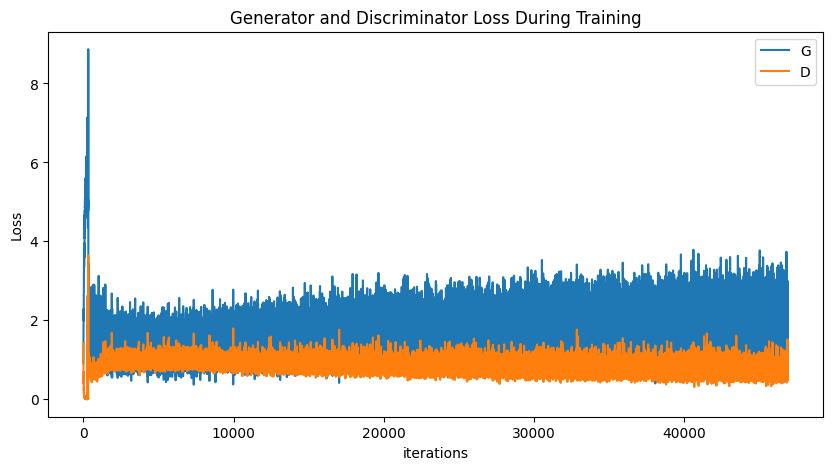

In [6]:
plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses, label="G")
plt.plot(D_losses, label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [7]:
def generate_and_visualize_images(generator, latent_dim, device, n_images=16):
    generator.eval()
    z = torch.randn(n_images, latent_dim, 1, 1, device=device)
    with torch.no_grad():
        generated_images = generator(z).cpu()

    fig, axes = plt.subplots(4, 4, figsize=(8, 8))
    for i, ax in enumerate(axes.flatten()):
        img = generated_images[i].squeeze().numpy()
        ax.imshow(img, cmap='gray')
        ax.axis('off')

    plt.tight_layout()
    plt.show()

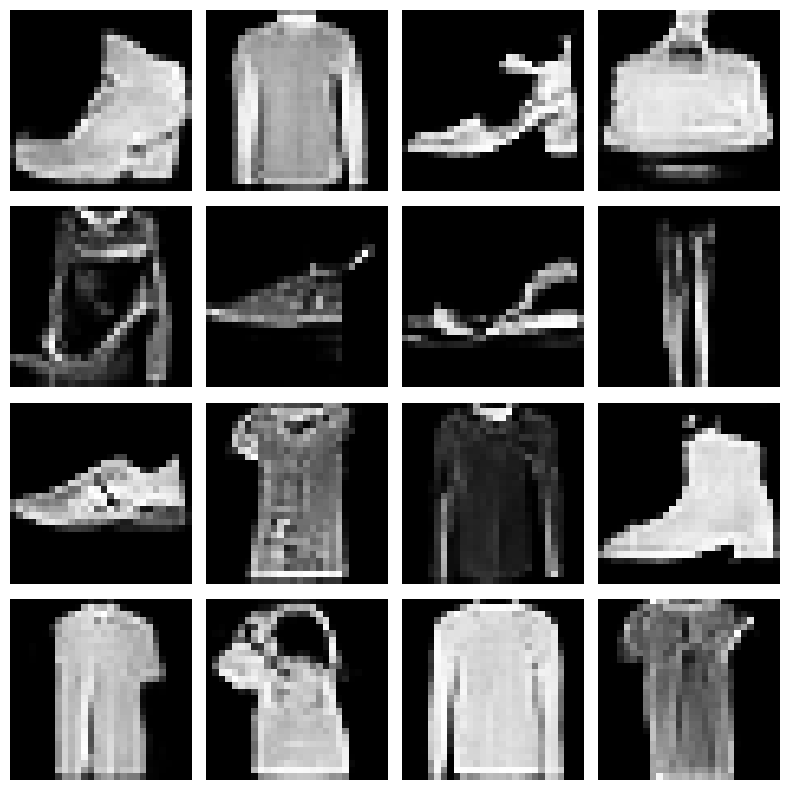

In [8]:
generate_and_visualize_images(generator, latent_dim, device)

#TensorFlow

In [9]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt

In [10]:
def make_generator_model():
    model = models.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

def make_discriminator_model():
    model = models.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))

    return model

In [11]:
# Load and preprocess the Fashion MNIST dataset
(train_images, train_labels), (_, _) = tf.keras.datasets.fashion_mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize to [-1, 1]

buffer_size = 60000
batch_size = 64

train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(buffer_size).batch(batch_size)

# Define hyperparameters
latent_dim = 100
num_epochs = 50
lr = 0.0002
beta1 = 0.5

4422102/4422102 [==============================] - 1s 0us/step


In [12]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator = make_generator_model()
discriminator = make_discriminator_model()

generator_optimizer = tf.keras.optimizers.Adam(lr, beta_1=beta1)
discriminator_optimizer = tf.keras.optimizers.Adam(lr, beta_1=beta1)

In [13]:
@tf.function
def train_step(images):
    noise = tf.random.normal([batch_size, latent_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

In [14]:
def train(dataset, epochs):
    G_losses = []
    D_losses = []

    for epoch in range(epochs):
        for image_batch in dataset:
            g_loss, d_loss = train_step(image_batch)

        G_losses.append(g_loss)
        D_losses.append(d_loss)

        print(f"Epoch {epoch+1}/{epochs}  Generator Loss: {g_loss}  Discriminator Loss: {d_loss}")

    return G_losses, D_losses

G_losses, D_losses = train(train_dataset, num_epochs)

/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5818: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Epoch 1/50  Generator Loss: 0.7893084287643433  Discriminator Loss: 1.3162935972213745
Epoch 2/50  Generator Loss: 1.1473934650421143  Discriminator Loss: 1.131364345550537
Epoch 3/50  Generator Loss: 0.8263481855392456  Discriminator Loss: 1.150849461555481
Epoch 4/50  Generator Loss: 0.774634599685669  Discriminator Loss: 1.34466552734375
Epoch 5/50  Generator Loss: 0.6965566277503967  Discriminator Loss: 1.3550286293029785
Epoch 6/50  Generator Loss: 0.6314704418182373  Discriminator Loss: 1.3467597961425781
Epoch 7/50  Generator Loss: 0.7130255103111267  Discriminator Loss: 1.383829951286316
Epoch 8/50  Generator Loss: 0.7068132162094116  Discriminator Loss: 1.3371777534484863
Epoch 9/50  Generator Loss: 0.7211320400238037  Discriminator Loss: 1.3968167304992676
Epoch 10/50  Generator Loss: 0.7291792631149292  Discriminator Loss: 1.425780177116394
Epoch 11/50  Generator Loss: 0.6859912276268005  Discriminator Loss: 1.3839802742004395
Epoch 12/50  Generator Loss: 0.7312987446784973 

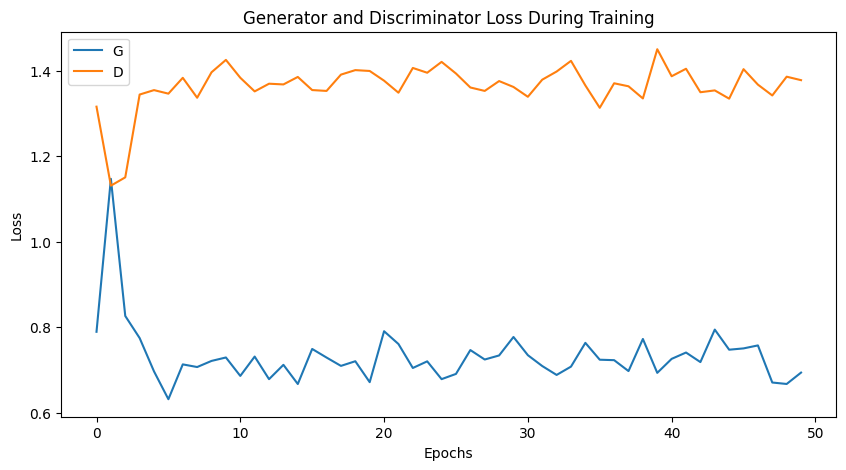

In [15]:
plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses, label="G")
plt.plot(D_losses, label="D")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

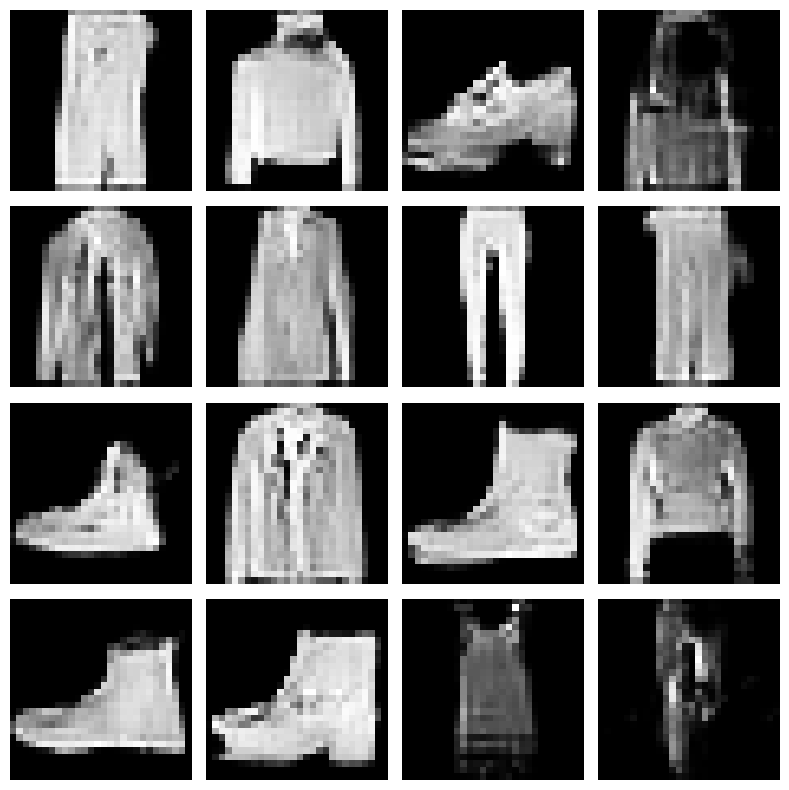

In [17]:
def generate_and_visualize_images(generator, latent_dim, n_images=16):
    noise = tf.random.normal([n_images, latent_dim])
    generated_images = generator(noise, training=False)

    fig, axes = plt.subplots(4, 4, figsize=(8, 8))
    for i, ax in enumerate(axes.flatten()):
        img = generated_images[i, :, :, 0] * 127.5 + 127.5
        ax.imshow(img, cmap='gray')
        ax.axis('off')

    plt.tight_layout()
    plt.show()

generate_and_visualize_images(generator, latent_dim)